<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.959 · Visualització de dades · PAC3
</p>
<p style="margin: 0; text-align:right;">2022-2 · Máster universitari en Ciencia de dades (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

**Nom: Víctor Iruela Garrido**

# Pràctica: Creació de la visualització i lliurament del projecte (2a part)
El següent codi ha estat creat i utilitzat per a processar i emmagatzemar diferents sets de dades per a poder fer les respectives representacions i la creació del vídeo.

# 2. Processament de les dades

En aquest apartat, partim del dataset únic creat a la part 1. S'implementen les funcions que permnitiran pintar i guardar els respectius gràfics que s'utilitzaran per a crear la imatge final que acabarà formant part del vídeo.

**Font de les dades**
- https://www.kaggle.com/datasets/moazzimalibhatti/co2-emission-by-countries-year-wise-17502022
- https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalLandTemperaturesByCountry.csv
- https://www.kaggle.com/datasets/kkhandekar/global-sea-level-1993-2021Ç

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
#MODIFICAR D'ACORD A LA RUTA DE LES TEVES CARPETES
#%cd /content/drive/MyDrive/Colab Notebooks/VISUALITZACIO/practica_final/

In [2]:
#!conda install -c conda-forge geoplot
#!conda install -c "conda-forge/label/cf201901" geoplot
#!conda install -c "conda-forge/label/cf202003" geoplot
#!conda install -c "conda-forge/label/gcc7" geoplot

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import geoplot as gplt
from geoplot import cartogram
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import mapclassify as mc
import pandas as pd
import country_converter as coco
from mpl_toolkits.axes_grid1 import make_axes_locatable
import imageio
import PIL
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import cv2 

Definim una funció que ens servirà per treure els valors únics d'una columna en una llista:

In [4]:
def unique_col_list(df, name_col):
    col_list = df[name_col].to_list()
    return np.unique(col_list)

Carreguem les dades, fem algunes transformacions i les explorem:

In [5]:
df_final = pd.read_csv('visualitzacio_practica_final_df.csv', index_col=[0])

# Transformem les tones en milions de tones. També arrodonim les temperatures:
df_final['CO2 emission (Tons)'] = (df_final['CO2 emission (Tons)'] / 1000000).round(0).astype('int')
df_final['AverageTemperature'] = (df_final['AverageTemperature']).round(1)

df_final.rename(columns={'CO2 emission (Tons)':'CO2 emission (million Tons)',
                         'AverageTemperature': 'AverageTemperature (°C)'}, inplace=True)

# A continuació, afegim una columna amb el codi del país amb format ISO3 (que
# és com estarà el dataset que conté la geometria del món):
cc = coco.CountryConverter()
countries = df_final['Country']
iso3_codes = cc.pandas_convert(series=countries, to='ISO3')
df_final.insert(4, "iso_a3", iso3_codes.to_list(), True)

Africa not found in regex
Asia not found in regex
Baker Island not found in regex
Europe not found in regex
North America not found in regex
Virgin Islands not found in regex
South America not found in regex
Oceania not found in regex
Kingman Reef not found in regex
Palmyra Atoll not found in regex


In [6]:
df_final.head()

,Year,Country,AverageTemperature (°C),CO2 emission (million Tons),iso_a3
0,1850,Afghanistan,13.3,0,AFG
1,1850,Africa,23.7,0,not found
2,1850,Albania,11.7,0,ALB
3,1850,Algeria,22.6,0,DZA
4,1850,Andorra,10.7,0,AND


Tornem a crear el dataset, que ja havíem creat a la primera part, que ens permetrà pintar els gràfics globals.

In [7]:
df_final_world = df_final.groupby(
    ['Year']).agg(
    {'CO2 emission (million Tons)': 'sum',
     'AverageTemperature (°C)': 'mean'}).reset_index()

df_final_world = df_final_world.reset_index(drop=True)
df_final_world.head()

,Year,CO2 emission (million Tons),AverageTemperature (°C)
0,1850,4758,16.906486
1,1851,4957,16.762428
2,1852,5165,15.923750
3,1853,5383,16.144379
4,1854,5638,16.260000


També rescatem la funció que havíem implementat per a crear els gràfics de línies, però afegim que es guardi la imatge.

In [8]:
def plot_df_cols(df, cols_plot, colors_dict, title, size, ylabel, year):
    plt_show = df.plot(
        x="Year", y=cols_plot, kind="line", figsize=size,
        title = "{} ({})".format(title, year),
        color=[colors_dict.get(x, '#333333') for x in cols_plot])
    plt_show.legend(fontsize=11, loc="upper left")
    plt_show.set_ylabel(ylabel)
    plt_show.axvline(year)
    plt_show.title.set_size(10)
    
    # Creem el directori images per a guardar les imatges:
    try:
        os.makedirs('images')
    except:
        pass

    # Guardem la imatge que formarà part de la visualització:
    plt.savefig('./images/{} ({}).png'.format(title, year), bbox_inches='tight')

Carreguem el dataset que conté les dades amb la geometria dels diferents països del món i explorem:

In [9]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
print(len(world))
world.head()

177


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


La següent funció servirà per pintar i guardar els diferents cartogrames:

In [10]:
def plot_cartogram(df, col_plot, scheme, year, size):
    # Exagerem l'escala per als valors més grans, per tal de cridar
    # l'atenció amb el canvi de tamany:
    weights = [1.75**i for i in range(len(scheme.bins))]
    scale = []
    for item in df[col_plot].to_list():
        index = 0
        for bean in scheme.bins:
            if item > bean:
                index += 1
        scale.append(item + weights[index])

    # load the data
    ax = gplt.cartogram(
        df,
        scale=scale,
        limits=(0.5, 2),
        projection=gcrs.PlateCarree(),
        hue=col_plot,
        cmap='YlOrRd',
        scheme=scheme,
        edgecolor='lightgray',
        linewidth=1,
        legend=True,
        legend_kwargs={'loc': 'lower left', 'fontsize': 8},
        legend_var='hue',
        figsize=size
    )
    gplt.polyplot(df, facecolor='lightgray', edgecolor='white', ax=ax)
    plt.title("{} ({})".format(col_plot, year))
    
    # Creem el directori images per a guardar les imatges:
    try:
        os.makedirs('images')
    except:
        pass

    # Guardem la imatge que formarà part de la visualització:
    plt.savefig('./images/{} ({}).png'.format(col_plot, year), bbox_inches='tight')

La següent funció ens facilita la feina de mostrar i guardar els dos diferents cartogrames (emissions de CO2 i mitjana de temperatures) per cada any.

In [11]:
def plot_cartogram_year(world_geopandas, df, year, size):
    CO2_col = 'CO2 emission (million Tons)'
    temp_col = 'AverageTemperature (°C)'
    
    divisions = 10
    CO2_Q = mc.Quantiles([0, 1, 10, 100, 1000, 10000, 100000, 380000], k=divisions)
    temps_Q = mc.Quantiles(df[temp_col], k=divisions)
    
    # Agafem el conjunt de dades només de l'any introduit per paràmetre:
    df_year = df[df['Year'] == year].reset_index(drop=True)
    
    # Juntem les dades que volem pintar amb el dataset que conté els polígons del mapa:
    df_world = world_geopandas.merge(df_year, how='left', on=['iso_a3']).fillna(0).reset_index(drop=True)
    
    # Cridem la funció anterior per a pintar cadascún dels cartogrames:
    plot_cartogram(df_world, CO2_col, CO2_Q, year, size)
    plot_cartogram(df_world, temp_col, temps_Q, year, size)

Finalment, fem un plot de cada tipus d'imatge que compondran les imatges finals que seran els fotogrames del vídeo.

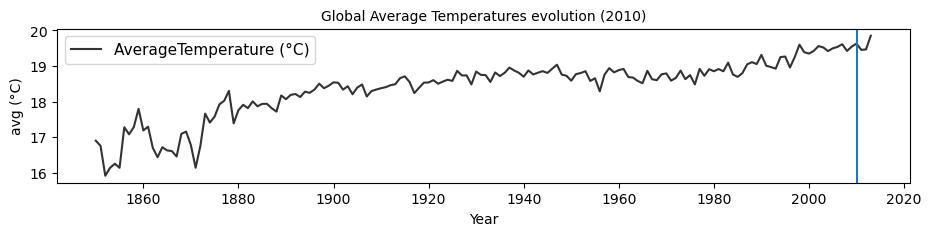

In [12]:
plot_df_cols(df_final_world, ['AverageTemperature (°C)'], {}, 'Global Average Temperatures evolution', (11, 2), 'avg (°C)', 2010)

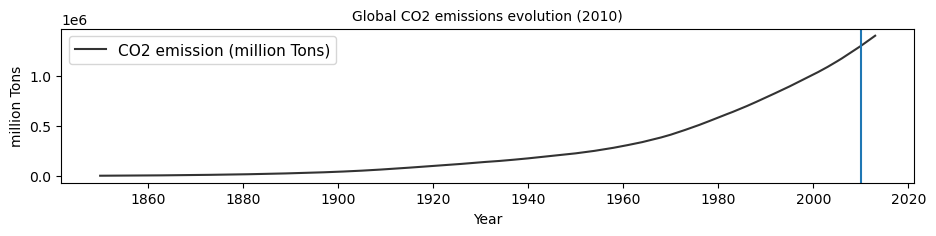

In [13]:
plot_df_cols(df_final_world, ['CO2 emission (million Tons)'], {}, 'Global CO2 emissions evolution', (11, 2), 'million Tons', 2010)

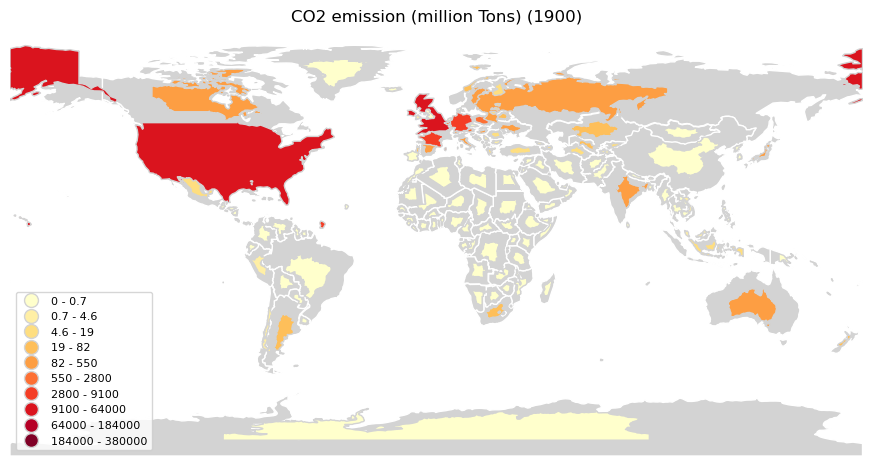

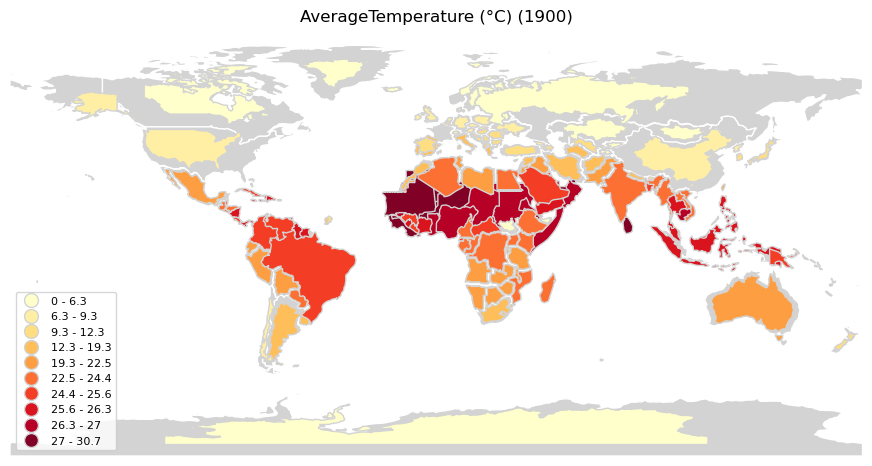

In [14]:
plot_cartogram_year(world, df_final, 1900, (11, 8))

# 3. Creació de la visualització (vídeo)

En aqesta part final, es processen les diferents imatges i es crea el vídeo.

In [15]:
##### Creem la següent funció per a juntar les imatges dels gràfics de línies amb els respectius cartogrames:
def _join_vertical(year, list_img_path, path):
    imgs = [Image.open(i) for i in list_img_path]
    # pick the image which is the smallest, and resize the others to match it (can be arbitrary image shape here)
    min_shape = sorted([(np.sum(i.size), i.size) for i in imgs])[0][1]
    low_image_shape = (min_shape[0], int(min_shape[1] * 2.5))

    # for a vertical stacking it is simple: use vstack
    imgs_comb = np.vstack([imgs[0].resize(min_shape), imgs[1].resize(low_image_shape)])
    imgs_comb = Image.fromarray(imgs_comb)
    imgs_comb.save(path)

# Creem la següent funció, per tal d'escriure la llicència, font i les nostres dades a cada imatge:
def _draw_text(img, text, colour, position):
    font = ImageFont.truetype("arial.ttf", 14)
    # Call draw Method to add 2D graphics in an image
    I1 = ImageDraw.Draw(img)
    # Add Text to an image
    I1.text(position, text, fill=colour, font=font)
    return img

# Amb la següent funció juntem les imatges horitzontalment, després d'haver juntat cada
# cartograma amb el seu gràfic de línies:
def join_year(year):
    CO2_paths = ["./images/Global CO2 emissions evolution ({}).png".format(year),
                 "./images/CO2 emission (million Tons) ({}).png".format(year)]
    _join_vertical(year, CO2_paths, "./images/CO2_{}.png".format(year))
    
    temps_paths = ["./images/Global Average Temperatures evolution ({}).png".format(year),
                   "./images/AverageTemperature (°C) ({}).png".format(year)]
    _join_vertical(year, temps_paths, "./images/temps_{}.png".format(year))
    
    list_im = ["./images/CO2_{}.png".format(year),
               "./images/temps_{}.png".format(year)]
    
    imgs = [Image.open(i) for i in list_im]
    # pick the image which is the smallest, and resize the others to match it (can be arbitrary image shape here)
    min_shape = sorted([(np.sum(i.size), i.size) for i in imgs])[0][1]
    imgs_comb = np.hstack([i.resize(min_shape) for i in imgs])

    # save that beautiful picture
    imgs_comb = Image.fromarray(imgs_comb)
    _draw_text(imgs_comb,
               'Video license: CC BY-SA 4.0\n'\
               'Author: Víctor Iruela Garrido'
               , 'black', (1669, 792))
    _draw_text(imgs_comb,
               'Data Sources:\n'\
               'https://www.kaggle.com/datasets/moazzimalibhatti/co2-emission-by-countries-year-wise-17502022\n'\
               'https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalLandTemperaturesByCountry.csv',
               'black', (170, 775))
    imgs_comb.save("./images/{}.png".format(year))

In [16]:
# Definim la segïemt funció per a pintar un any:
def plot_and_save_year(year):
    plot_df_cols(df_final_world, ['AverageTemperature (°C)'], {}, 'Global Average Temperatures evolution', (11, 2), 'avg (°C)', year)
    plot_df_cols(df_final_world, ['CO2 emission (million Tons)'], {}, 'Global CO2 emissions evolution', (11, 2), 'million Tons', year)
    plot_cartogram_year(world, df_final, year, (11, 8))
    join_year(year)

In [ ]:
# Guardem tots els anys:
for year in unique_col_list(df_final, 'Year'):
    plot_and_save_year(year)

Un cop guardades totes les imatges, creem la següent funció per a generar el vídeo:

In [18]:
def generate_video(path, file_name, years, fps=20):
    images = ["{}{}.png".format(path, year) for year in years]
    frame = cv2.imread(images[0])
  
    # setting the frame width, height width
    # the width, height of first image
    height, width, layers = frame.shape  
  
    video = cv2.VideoWriter("{}.mp4".format(file_name), 0, 5.4, (width, height)) 
  
    # Appending the images to the video one by one
    for image in images:
        video.write(cv2.imread(image))
    
    # Afegim 5 segons al final, per a donnar temps a reflexionar:
    for i in range(27):
        video.write(cv2.imread(image))
      
    # Deallocating memories taken for window creation
    cv2.destroyAllWindows() 
    video.release()  # releasing the video generated

In [19]:
generate_video("./images/", "./videos/CO2_and_temps_EVOL", unique_col_list(df_final, 'Year'), fps=20)

**Referències**
- https://medium.com/analytics-vidhya/fastest-way-to-install-geopandas-in-jupyter-notebook-on-windows-8f734e11fa2b
- https://residentmario.github.io/geoplot/user_guide/Customizing_Plots.html
- https://residentmario.github.io/geoplot/api_reference.html#plots
- https://snyk.io/advisor/python/geoplot/functions/geoplot.cartogram
- https://geopandas.org/en/v0.5.0/gallery/plotting_with_geoplot.html
- https://residentmario.github.io/geoplot/gallery/plot_obesity.html
- https://download.osgeo.org/livedvd/tmp_stor/gpd_0102/gallery/plotting_with_geoplot.html
- https://residentmario.github.io/geoplot/plot_references/plot_reference.html
- https://www.geografiainfinita.com/2015/03/la-culpa-no-es-de-mercator/
- https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html
- https://stackoverflow.com/questions/30227466/combine-several-images-horizontally-with-python
- https://www.geeksforgeeks.org/python-create-video-using-multiple-images-using-opencv/
- https://docs.opencv.org/3.4/dd/d9e/classcv_1_1VideoWriter.html
- https://www.geeksforgeeks.org/adding-text-on-image-using-python-pil/
- https://creativecommons.org/licenses/by-sa/4.0/